## Neural networks for segmentation

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import imageio
%matplotlib inline

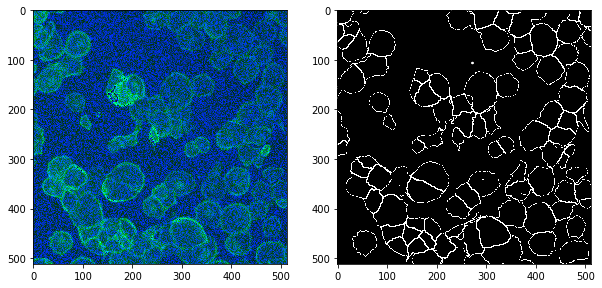

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = imageio.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imageio.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [3]:
def plot_sample_with_mask(data):
    image, mask = data
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

# Let's start

In [4]:
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io, transform

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import sigmoid

from torchvision.transforms import functional as F
import PIL

from IPython.display import clear_output

import tqdm
import numbers

from torchvision.transforms import Lambda, Compose

In [5]:
device = torch.device("cuda")

### Dataset

Create custom dataset class to load simultaneously image and mask.

In [6]:
class CellDataset(Dataset):
    
    def __init__(self, images_path, masks_path, transform=None):
        self.images_pathes = sorted(glob.glob("{}/*".format(images_path)))
        self.masks_pathes = sorted(glob.glob("{}/*".format(masks_path)))
        self.transform = transform
    
    def __getitem__(self, index):
        image = np.array(imageio.imread(self.images_pathes[index], ))
        mask = np.array(imageio.imread(self.masks_pathes[index]))
        
        sample = (image, mask)
        
        if self.transform:
            return self.transform(sample)
        
        return sample
    
    def __len__(self):
        return len(self.images_pathes)

### Augmentation

Create augmentation transforms methods to randomly do the same stuff for image and its mask.

In [7]:
class ToPILImage(object):
    
    def __call__(self, sample):
        image, mask = sample
        return F.to_pil_image(image), F.to_pil_image(mask)
    
class Rescale(object):
   
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample

        new_image = F.resize(image, self.output_size, PIL.Image.BILINEAR)
        new_mask = F.resize(mask, self.output_size, PIL.Image.BILINEAR)
        
        return new_image, new_mask
    
class CenterCrop(object):
    
    def __init__(self, size):
        self.size = size
        
    def __call__(self, sapmle):
        image, mask = sapmle
        
        return F.center_crop(image, self.size), F.center_crop(mask, self.size)
    
    
class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        transforms = []

        if brightness is not None:
            brightness_factor = np.random.uniform(brightness[0], brightness[1])
            transforms.append(Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = np.random.uniform(contrast[0], contrast[1])
            transforms.append(Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = np.random.uniform(saturation[0], saturation[1])
            transforms.append(Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = np.random.uniform(hue[0], hue[1])
            transforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        np.random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, sample):
        image, mask = sample
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
        return transform(image), mask
    
class RandomHorizontalFlip(object):
    
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        image, mask = sample
        
        if np.random.rand() < self.p:
            return F.hflip(image), F.hflip(mask)
        
        return image, mask
        
        
class RandomVerticalFlip(object):
    
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        image, mask = sample
        
        if np.random.rand() < self.p:
            return F.vflip(image), F.vflip(mask)
        
        return image, mask
    
    
class RandomRotation(object):
    
    def __init__(self, angle):
        self.angle = angle
        
    def __call__(self, sample):
        image, mask = sample
        
        angle = np.random.uniform(-self.angle, self.angle)
        return F.rotate(image, angle), F.rotate(mask, angle)
    

class RandomCrop(object):
  
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        new_image = image[top: top + new_h, left: left + new_w]
        new_mask = mask[top: top + new_h, left: left + new_w]
        
        return new_image, new_mask

class ToTensor(object):
    
    def __call__(self, sample):
        image, mask = sample
        mask = F.to_tensor(mask).type(torch.LongTensor)
        mask[mask > 0] = 1
        
        return F.to_tensor(image), mask.squeeze(0)

### Model

Use `U-Net`-like architecture of convolutional neural net.

In [8]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )   
    
    def forward(self, x):
        return self.block(x) 


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        
        self.up3 = DoubleConv(256 + 512, 256)
        self.up2 = DoubleConv(128 + 256, 128)
        self.up1 = DoubleConv(128 + 64, 64)
        
        self.out = nn.Conv2d(64, n_class, 1)
        
    def _upsample(self, x):
        return nn.functional.interpolate(x, scale_factor=2,
                                         mode="bilinear", align_corners=True)
        
    def forward(self, x):
        conv1 = self.down1(x)
        x = self.maxpool(conv1)
        conv2 = self.down2(x)
        x = self.maxpool(conv2)
        conv3 = self.down3(x)
        x = self.maxpool(conv3)   
        x = self.down4(x)
        
        x = self._upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.up3(x)
        x = self._upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.up2(x)
        x = self._upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.up1(x)
        
        out = self.out(x)
        return out

Init augmentations for train and validation sets

In [9]:
train_transform = transforms.Compose([
    ToPILImage(),
    ColorJitter(0.5, 0.5, 0.5, 0.001),
    RandomHorizontalFlip(0.5),
    RandomVerticalFlip(0.5),
    RandomRotation(90),
    CenterCrop(384),
    ToTensor()
])

val_transform = transforms.Compose([
    ToPILImage(),
    ToTensor()
])

In [10]:
train_dataset = CellDataset("./BBBC018_v1_images-fixed/train/", "./BBBC018_v1_outlines/train/", train_transform)
val_dataset = CellDataset("./BBBC018_v1_images-fixed/train/", "./BBBC018_v1_outlines/train/", val_transform)

Look at random augmentations for the same input

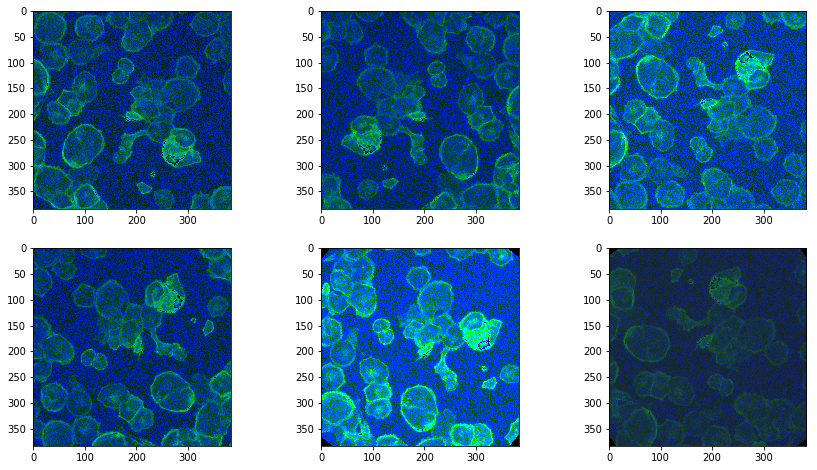

In [11]:
fig = plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    ax.imshow((train_dataset[0][0].permute(1, 2, 0).numpy() * 255).astype(int))

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

### Train

Let's go

In [13]:
model = UNet(2)
model.to(device)
model.train()

opt = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [20]:
n_epochs = 30
repeats_per_epoch = 5

Epoch: 29 Train loss: 0.09765041
Epoch: 29 Val loss: 0.09574791


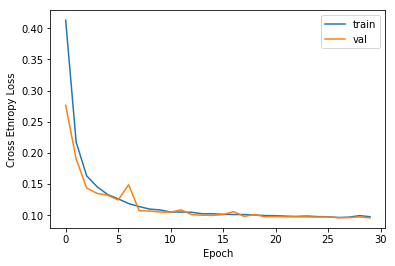

In [21]:
#train_epoch_losses, val_epoch_losses = [], []
for epoch in range(20, n_epochs):
    
    model.train()
    train_losses = []
    for repeat in range(repeats_per_epoch):
        for data in train_dataloader:
            out = model(data[0].to(device))
            model.zero_grad()
            loss = criterion(out, data[1].to(device))
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
            
    train_epoch_losses.append(np.mean(train_losses))
        
    model.eval()
    val_losses = []
    for data in val_dataloader:
        out = model(data[0].to(device))
        loss = criterion(out, data[1].to(device))
        val_losses.append(loss.item())
    
    val_epoch_losses.append(np.mean(val_losses))
    
    clear_output()
    
    print("Epoch:", epoch, "Train loss: {:.8f}".format(train_epoch_losses[-1]))
    print("Epoch:", epoch, "Val loss: {:.8f}".format(val_epoch_losses[-1]))
    
    plt.plot(train_epoch_losses, label="train")
    plt.plot(val_epoch_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Etnropy Loss")
    plt.legend()
    
    plt.show()

### Calc validation metric

In [82]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [52]:
def calc_best_threshold(predict, target):
    best_iou, best_th = None, None
    
    for th in np.arange(0.01, 1, 0.01):
        img = predict > th
        iou = calc_iou(img, target)
        if best_iou is None or iou > best_iou:
            best_iou, best_th = iou, th
    
    return best_th, best_iou

Find probability threshold to maximize `IoU` metric by first valiatoin example.

In [164]:
data = val_dataset[0]
target = data[1].data.numpy()
out = model(data[0].unsqueeze(0).to(device)).cpu()
predict = torch.nn.functional.softmax(out, dim=1).data.numpy()[0][1]

In [165]:
theta, iou = calc_best_threshold(predict, target)
print("Theta: {:.3f} IoU: {:.3f}".format(theta, iou))

Theta: 0.210 IoU: 0.334


Calc metric at other validation examples.

In [166]:
ious = []
for idx in range(1, len(val_dataset)):
    data = val_dataset[idx]
    
    target = data[1].data.numpy()
    out = model(data[0].unsqueeze(0).to(device)).cpu()
    predict = torch.nn.functional.softmax(out, dim=1).data.numpy()[0][1]
    
    ious.append(calc_iou(predict > theta, target))
    
print("Mean validation IoU: {:.3f}".format(np.mean(ious)))

Mean validation IoU: 0.302


### Predict test

In [135]:
class CellTestDataset(Dataset):
    
    def __init__(self, images_path, transform=None):
        self.images_pathes = sorted(glob.glob("{}/*".format(images_path)))
        self.transform = transform
    
    def __getitem__(self, index):
        image = np.array(imageio.imread(self.images_pathes[index], ))
        
        if self.transform:
            return self.transform(image), self.images_pathes[index]
        
        return image, self.images_pathes[index]
    
    def __len__(self):
        return len(self.images_pathes)

In [136]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [137]:
test_dataset = CellTestDataset("./BBBC018_v1_images-fixed/test/", test_transform)
test_images_dataset = CellTestDataset("./BBBC018_v1_images-fixed/test/", None)

In [138]:
test_images, test_masks, test_pathes = [], [], []

for idx in range(len(test_dataset)):
    out = model(test_dataset[idx][0].unsqueeze(0).to(device)).cpu()
    predict = torch.nn.functional.softmax(out, dim=1).data.numpy()[0][1]
    
    test_images.append(test_images_dataset[idx][0])
    test_masks.append(predict > theta)
    test_pathes.append(test_dataset[idx][1])

Look at test predictoins

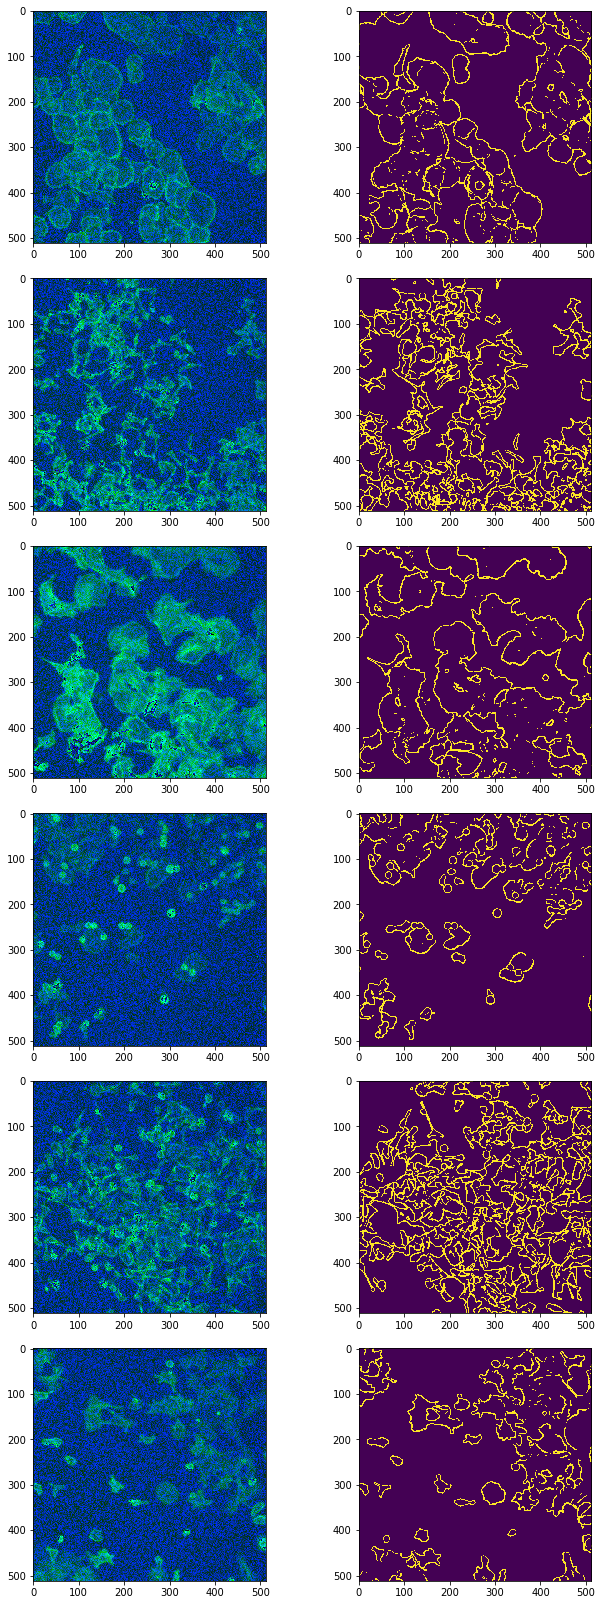

In [154]:
fig = plt.figure(figsize=(10, 34))
fig.subplots_adjust(hspace=0.1, wspace=0.4)

for i in range(6):
    ax = fig.add_subplot(7, 2, 2 * i + 1)
    ax.imshow(test_images[i])
    
    ax = fig.add_subplot(7, 2, 2 * i + 2)
    ax.imshow(test_masks[i])

In [150]:
# save tests masks
for test_path, test_mask in zip(test_pathes, test_masks):
    basename = os.path.basename(test_path)
    image = (test_mask * 255).astype(np.uint8)
    imageio.imwrite("out/{}".format(basename), image)